In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
])

In [ ]:
!unzip -qq ./chip_data.zip -d data


replace data/dataset/test/defect/D2_C97.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace data/dataset/test/defect/D1_C513.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace data/dataset/test/defect/D0_C48.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [ ]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image.numpy())  # Convert to numpy for visualization
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

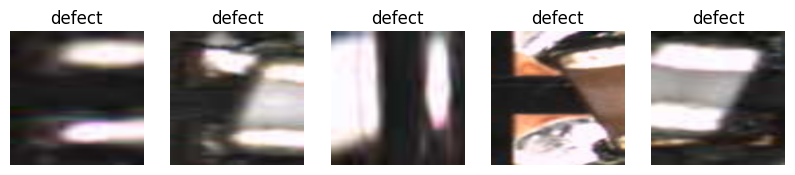

In [ ]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [ ]:
print(f"Total number of training samples: {len(train_dataset)}")
print(f"Total number of testing samples: {len(test_dataset)}")
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Total number of testing samples: 121
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
from torchvision.models import VGG19_Weights
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 114MB/s] 


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Modify the final fully connected layer to match the dataset classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: DIVYA DHARSHINI R        ")
    print("Register Number: 212223040042        ")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/10], Train Loss: 0.8471, Validation Loss: 0.2303
Epoch [2/10], Train Loss: 0.2844, Validation Loss: 0.1290
Epoch [3/10], Train Loss: 0.0511, Validation Loss: 0.1974
Epoch [4/10], Train Loss: 0.0068, Validation Loss: 0.2199
Epoch [5/10], Train Loss: 0.0022, Validation Loss: 0.2499
Epoch [6/10], Train Loss: 0.0012, Validation Loss: 0.1610
Epoch [7/10], Train Loss: 0.6176, Validation Loss: 0.7990
Epoch [8/10], Train Loss: 0.4555, Validation Loss: 1.0509
Epoch [9/10], Train Loss: 0.1791, Validation Loss: 0.2150
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 1.7129
Name: DIVYA DHARSHINI R        
Register Number: 212223040042        


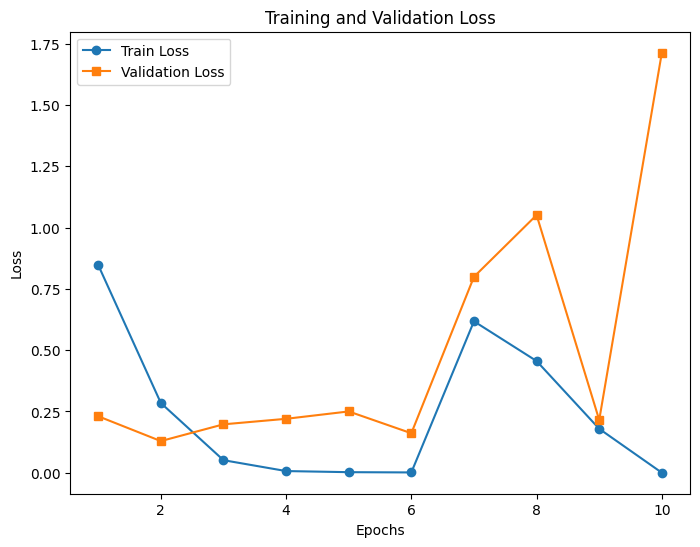

In [ ]:
# Train the model
train_model(model, train_loader, test_loader, num_epochs=10)

In [23]:
## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:DIVYA DHARSHINI R       ")
    print("Register Number: 212223040042        ")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name: DIVYA DHARSHINI R       ")
    print("Register Number: 212223040042        ")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Test Accuracy: 0.9091
Name:DIVYA DHARSHINI R       
Register Number: 212223040042        


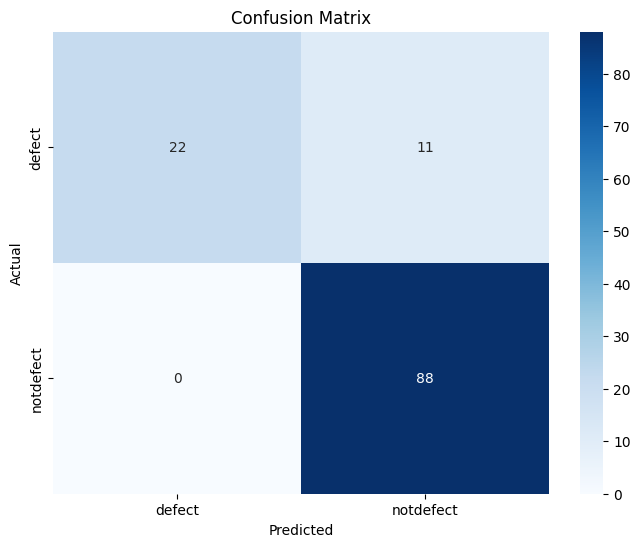

Name: DIVYA DHARSHINI R       
Register Number: 212223040042        
Classification Report:
              precision    recall  f1-score   support

      defect       1.00      0.67      0.80        33
   notdefect       0.89      1.00      0.94        88

    accuracy                           0.91       121
   macro avg       0.94      0.83      0.87       121
weighted avg       0.92      0.91      0.90       121



In [22]:
# Evaluate the model
test_model(model, test_loader)

In [24]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        # The image is already a tensor, just add batch dimension and send to device
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes  # Get class labels

    # Display the image
    # Need to convert the image back to PIL format for display
    image_to_display = transforms.ToPILImage()(image)
    print("Name: DIVYA DHARSHINI R        ")
    print("Register Number: 212223040042        ")
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()

Name: DIVYA DHARSHINI R        
Register Number: 212223040042        


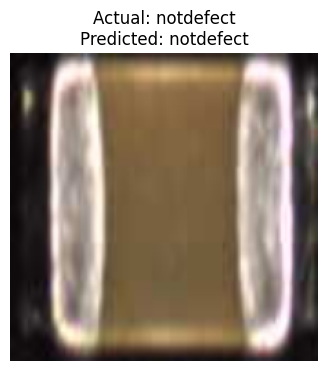

In [25]:
# Example Prediction
predict_image(model, image_index=55, dataset=test_dataset)

Name: DIVYA DHARSHINI R        
Register Number: 212223040042        


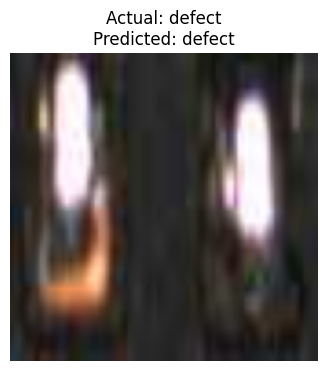

In [26]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)